In [90]:
# Test emulator

In [2]:
from cosmopower import cosmopower_NN
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [7]:
# Function that calls the trained neural network and calculates the non linear power spectrum based on the desired parameters
def non_linear_spectrum(omega_b, omega_c, A_s_1e9, n_s, xi, h, z):
    cp_nn = cosmopower_NN(restore=True, 
                      restore_filename='trained_model',
                      )
    
    parameters = {'omega_b': [omega_b], 
                  'omega_c': [omega_c], 
                  'A_s_1e9': [A_s_1e9], 
                  'n_s': [n_s], 
                  'xi': [xi],
                  'h': [h],
                  'z': [z],
                 }

    power_spectra = cp_nn.predictions_np(parameters)[0]
    power_spectra = gaussian_filter(power_spectra, sigma=2.5)

    k_modes = cp_nn.modes

    return power_spectra, k_modes

power_spectra, k_modes = non_linear_spectrum(0.05, 0.3, 2, 0.96, 0, 0.7, 0)

In [35]:
#Calculate the original spectrum for the desired parameters just for comparison, not necessary
from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann, linear_power, growth,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
from pmwd.spec_util import powspec
from pmwd.pm_util import fftinv
from pmwd.vis_util import simshow

ptcl_spacing = 1.           
ptcl_grid_shape = (128,) * 3  
conf = Configuration(ptcl_spacing, ptcl_grid_shape, a_stop=1/(1+0), mesh_shape=2)  

cosmo = Cosmology(conf, A_s_1e9=2, n_s=0.96, Omega_c=0.3, Omega_b=0.05, xi_=0, h=0.7)
cosmo = boltzmann(cosmo, conf)

seed = 0
modes = white_noise(seed, conf)
modes = linear_modes(modes, cosmo, conf)
    
ptcl, obsvbl = lpt(modes, cosmo, conf)
ptcl.disp.std(), ptcl.vel.std()
    
ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
ptcl.disp.std(), ptcl.vel.std()

dens = scatter(ptcl, conf)
k, P, _, _ = powspec(dens, conf.cell_size)
P = gaussian_filter(P, sigma=2.5)

dens_lin = fftinv(modes, shape=conf.ptcl_grid_shape, norm=conf.ptcl_spacing)
dens_lin *= growth(conf.a_stop, cosmo, conf)

k_lin, P_lin, _, _ = powspec(dens_lin, conf.ptcl_spacing)
P_lin = gaussian_filter(P_lin, sigma=2.5)

P_linth = linear_power(k, conf.a_stop, cosmo, conf)
P_linth = gaussian_filter(P_linth, sigma=2.5)

In [23]:
k_class = np.logspace(-5, np.log10(5.8), num=1000)

from classy import Class

cosmo = Class()

# Define your cosmology (what is not specified will be set to CLASS default parameters)
params = {'output': 'mPk',
          'z_max_pk': 10,
          'P_k_max_1/Mpc': 10.,
          'non linear': 'halofit',
          'omega_b': 0.0245,
          'omega_cdm': 0.147,
          'h': 0.7,
          'n_s': 0.96,
          'A_s': 2e-9,
          'w0_fld': -1.01,       
          'wa_fld': 0.0,          
          'Omega_Lambda': 0.0,             
         }

# Set the parameters to the cosmological code
cosmo.set(params)
cosmo.compute()

z = 0

spectrum_class = np.array([cosmo.pk(ki, z) for ki in k_class])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k_class])

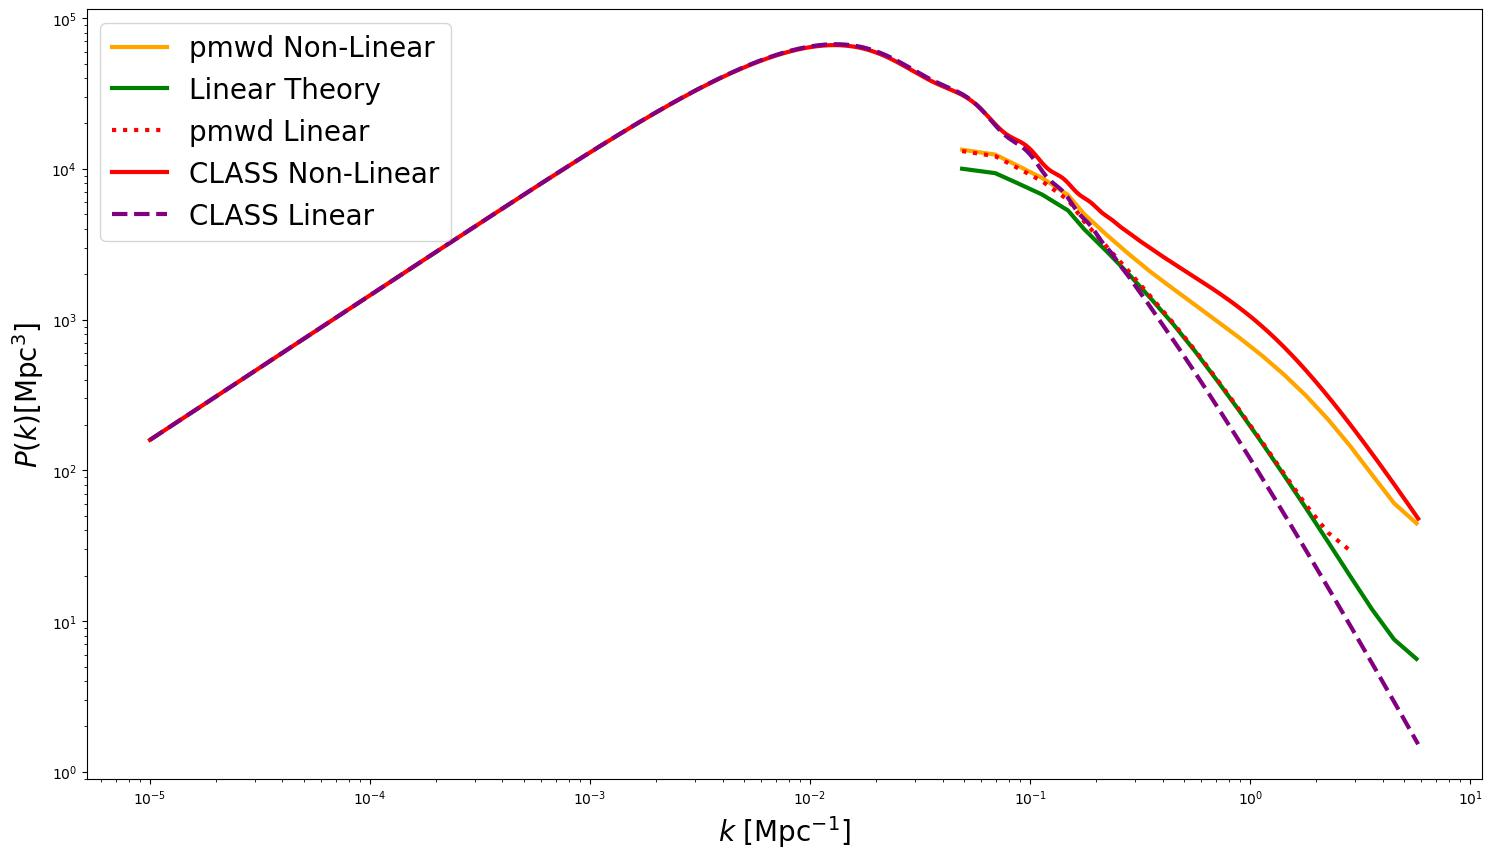

In [36]:
# Graphic comparison
fig = plt.figure(figsize=(18,10))
plt.loglog(k, P, 'orange', label = 'pmwd Non-Linear', linewidth=3)
plt.loglog(k, P_linth, 'green', label = 'Linear Theory', linewidth=3)
#plt.loglog(k_modes, power_spectra, 'blue', label = 'CosmoPower Non-Linear', linestyle =  '--',linewidth=3)
plt.loglog(k_lin, P_lin, 'red', label = 'pmwd Linear', linestyle =  ':',linewidth=3)
plt.loglog(k_class, spectrum_class, 'red', label = 'CLASS Non-Linear', linewidth=3)
plt.loglog(k_class, Plin, 'purple', label = 'CLASS Linear', linestyle =  '--', linewidth=3)
plt.xlabel('$k$ [Mpc$^{-1}]$', fontsize=20)
plt.ylabel('$P(k)[\mathrm{Mpc}^3]$', fontsize=20)
#plt.xlim(0.05,5)
plt.legend(fontsize=20)
plt.savefig('comparison')

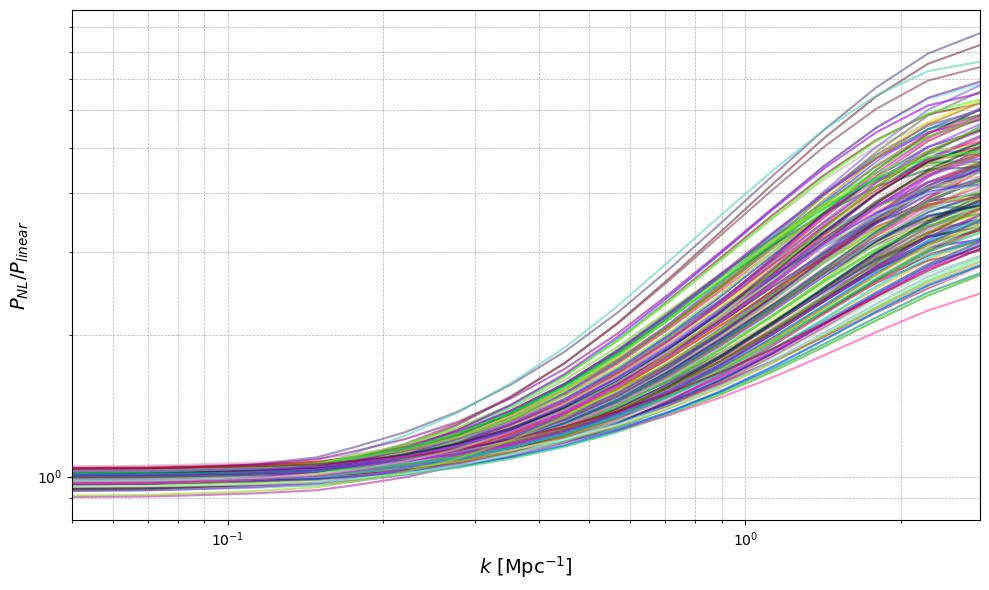

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from scipy.ndimage import gaussian_filter

# Diretório onde estão os 10000 arquivos
data_directory = "IDE"

# Lista de todos os arquivos no diretório
all_files = [f for f in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, f))]

# Selecionar 10000 arquivos aleatórios
random_files = random.sample(all_files, 10000)

# Parâmetro para filtrar os arquivos (exemplo: valores em uma coluna específica)
param_column_index = 4  # Índice da coluna a ser analisada
value_threshold = -0.01   # Limite para o parâmetro

# Inicializar o gráfico
plt.figure(figsize=(10, 6))

# Iterar sobre os arquivos selecionados
for file in random_files:
    file_path = os.path.join(data_directory, file)
    
    # Carregar os dados do arquivo
    data = np.loadtxt(file_path)
    
    # Verificar se o arquivo atende à condição
    if np.any(data[:, param_column_index] > value_threshold):  # Ajuste o operador e o valor conforme necessário
        # Extrair as colunas relevantes
        xi = data[:, 4]
        k_modes = data[:, 7]  # Modos de k
        P_nonlinear = data[:, 8]  # Espectro não linear
        P_linear = data[:, 10]  # Espectro linear
        
        # Calcular a razão
        P_nonlinear = gaussian_filter(P_nonlinear, sigma=2.5)
        P_linear = gaussian_filter(P_linear, sigma=2.5)
        ratio = P_nonlinear / P_linear
        
        # Escolher uma cor aleatória para este arquivo
        color = np.random.rand(3,)  # Gera um RGB aleatório
        
        # Adicionar ao gráfico
        plt.plot(k_modes, ratio, alpha=0.6, color=color)

# Configurar o gráfico
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$ [Mpc$^{-1}]$', fontsize=14)
plt.ylabel('$P_{NL} / P_{linear}$', fontsize=14)
plt.xlim(0.05, 2.8422)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig('ratio_001')

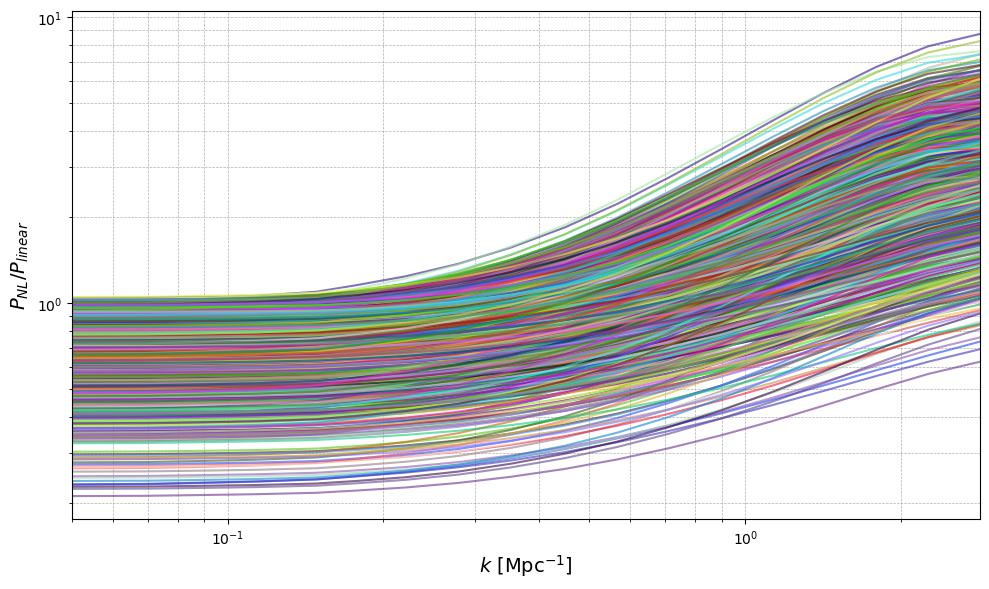

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from scipy.ndimage import gaussian_filter

# Diretório onde estão os 10000 arquivos
data_directory = "IDE"

# Lista de todos os arquivos no diretório
all_files = [f for f in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, f))]


# Selecionar 10000 arquivos aleatórios
random_files = random.sample(all_files, 10000)

# Parâmetro para filtrar os arquivos (exemplo: valores em uma coluna específica)
param_column_index = 4  # Índice da coluna a ser analisada
value_threshold = -0.1   # Limite para o parâmetro

# Inicializar o gráfico
plt.figure(figsize=(10, 6))

# Iterar sobre os arquivos selecionados
for file in random_files:
    file_path = os.path.join(data_directory, file)
    
    # Carregar os dados do arquivo
    data = np.loadtxt(file_path)
    
    # Verificar se o arquivo atende à condição
    if np.any(data[:, param_column_index] > value_threshold):  # Ajuste o operador e o valor conforme necessário
        # Extrair as colunas relevantes
        xi = data[:, 4]
        k_modes = data[:, 7]  # Modos de k
        P_nonlinear = data[:, 8]  # Espectro não linear
        P_linear = data[:, 10]  # Espectro linear
        
        # Calcular a razão
        P_nonlinear = gaussian_filter(P_nonlinear, sigma=2.5)
        P_linear = gaussian_filter(P_linear, sigma=2.5)
        ratio = P_nonlinear / P_linear
        
        # Escolher uma cor aleatória para este arquivo
        color = np.random.rand(3,)  # Gera um RGB aleatório
        
        # Adicionar ao gráfico
        plt.plot(k_modes, ratio, alpha=0.6, color=color)

# Configurar o gráfico
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$ [Mpc$^{-1}]$', fontsize=14)
plt.ylabel('$P_{NL} / P_{linear}$', fontsize=14)
plt.xlim(0.05, 2.8422)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig('ratio_01')

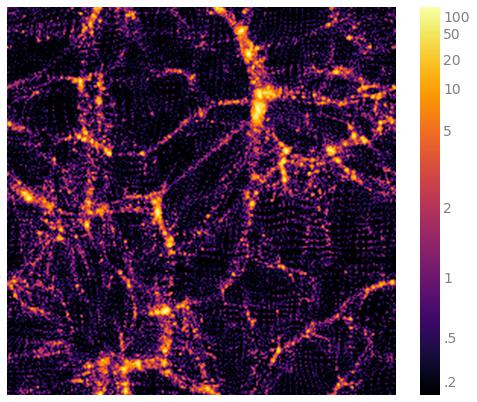

In [128]:
dens = scatter(ptcl, conf)
simshow(dens[:16].mean(axis=0), norm='CosmicWebNorm');

Parâmetros do conjunto 1:
  ω_b = 0.0450, ω_c = 0.2936, A_s_1e9 = 2.3054, n_s = 1.0372, ξ = -0.2825, h = 0.6191, z = 0.0000



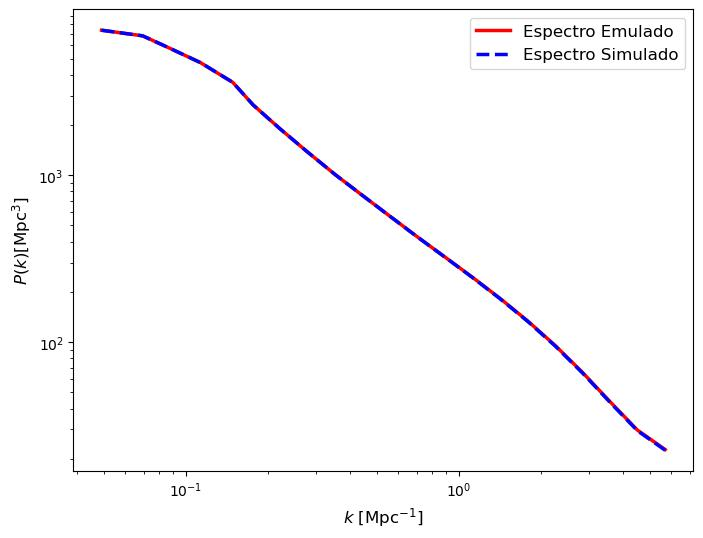

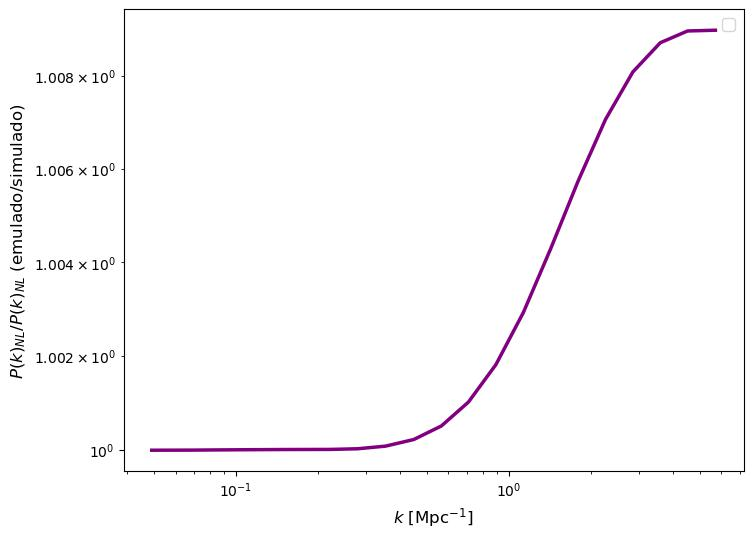

Parâmetros do conjunto 2:
  ω_b = 0.0477, ω_c = 0.1098, A_s_1e9 = 1.9055, n_s = 0.9159, ξ = -0.2754, h = 0.5305, z = 0.0000



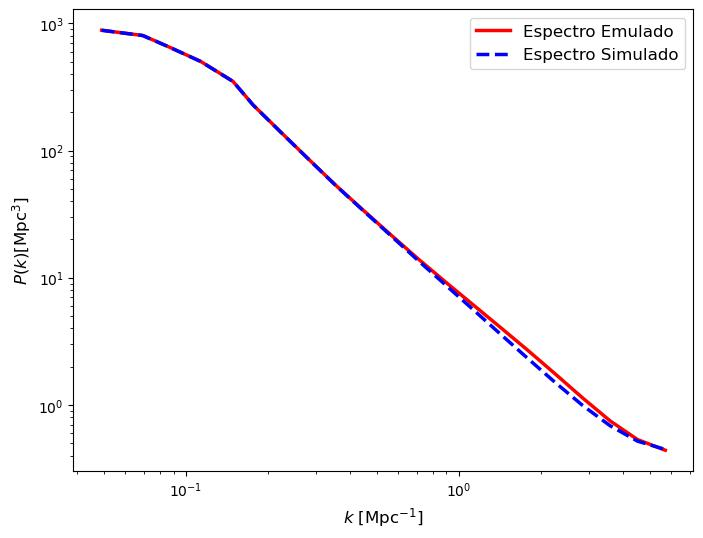

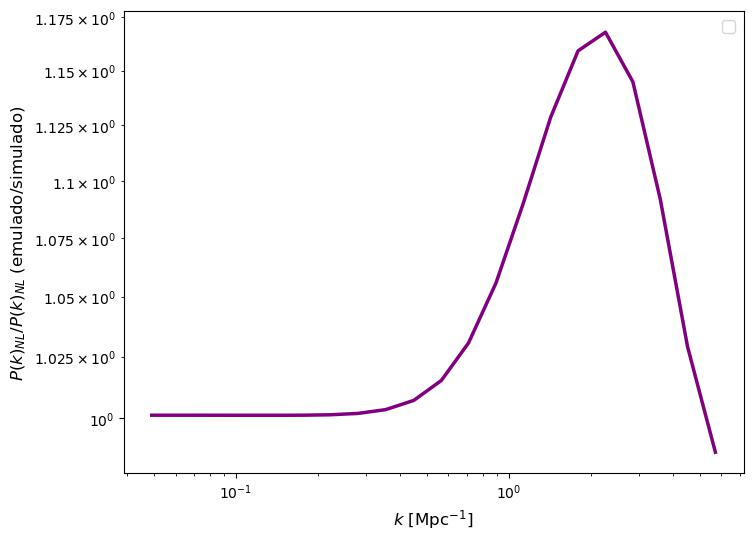

Parâmetros do conjunto 3:
  ω_b = 0.0418, ω_c = 0.4484, A_s_1e9 = 2.0938, n_s = 0.9365, ξ = -0.3113, h = 0.4188, z = 0.0000



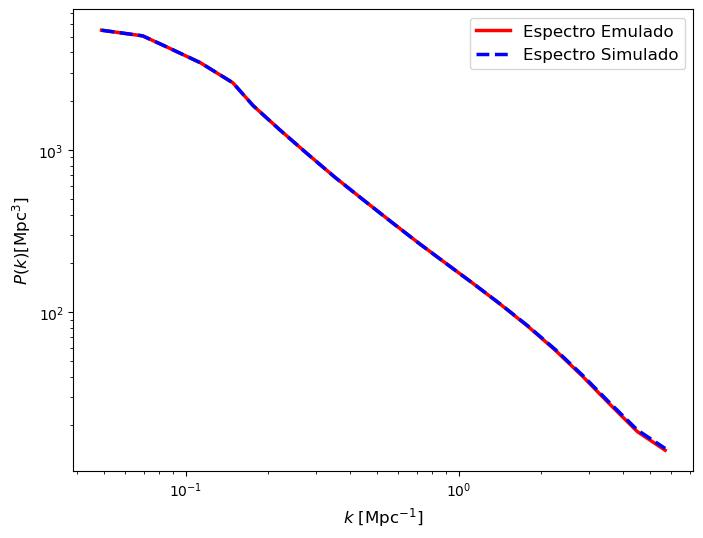

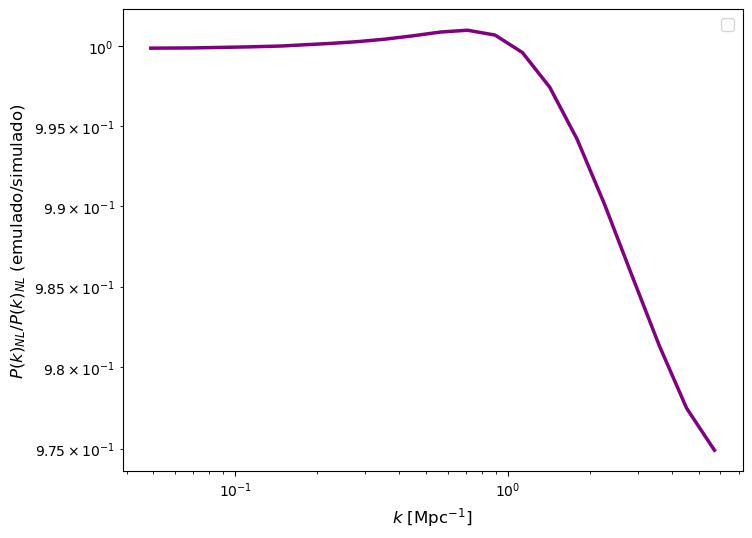

Parâmetros do conjunto 4:
  ω_b = 0.0517, ω_c = 0.2408, A_s_1e9 = 1.7644, n_s = 0.9662, ξ = -0.3352, h = 0.7823, z = 0.0000



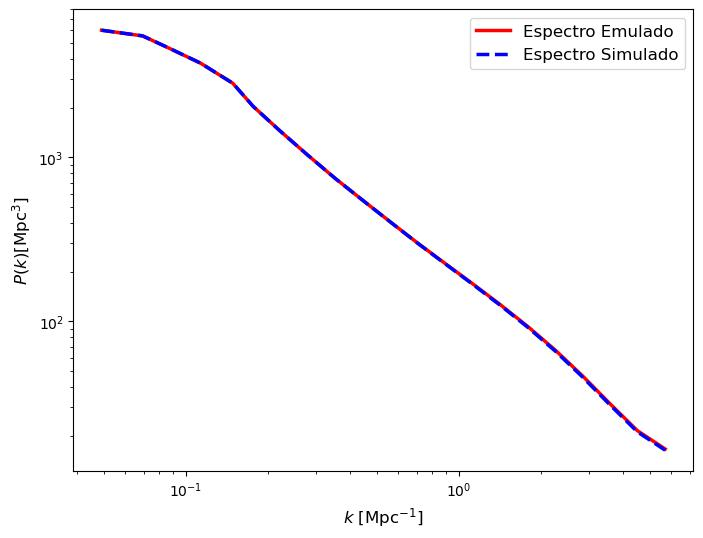

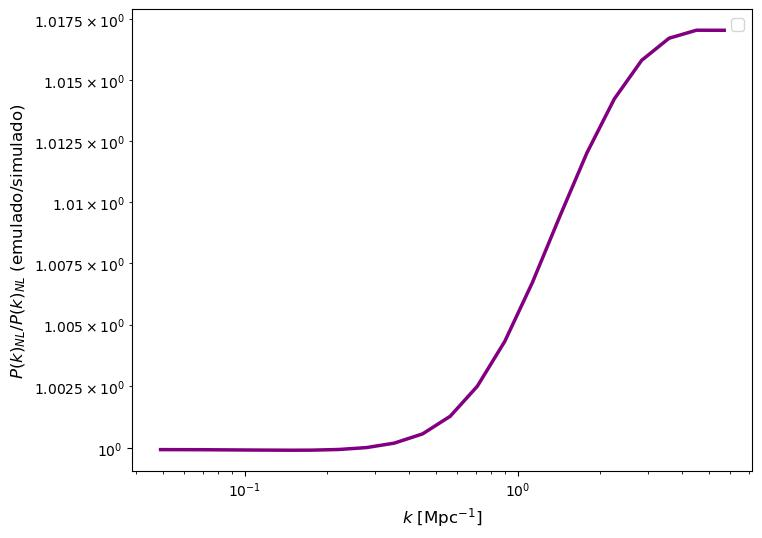

Parâmetros do conjunto 5:
  ω_b = 0.0464, ω_c = 0.4147, A_s_1e9 = 2.3727, n_s = 0.9810, ξ = -0.2119, h = 0.7466, z = 0.0000



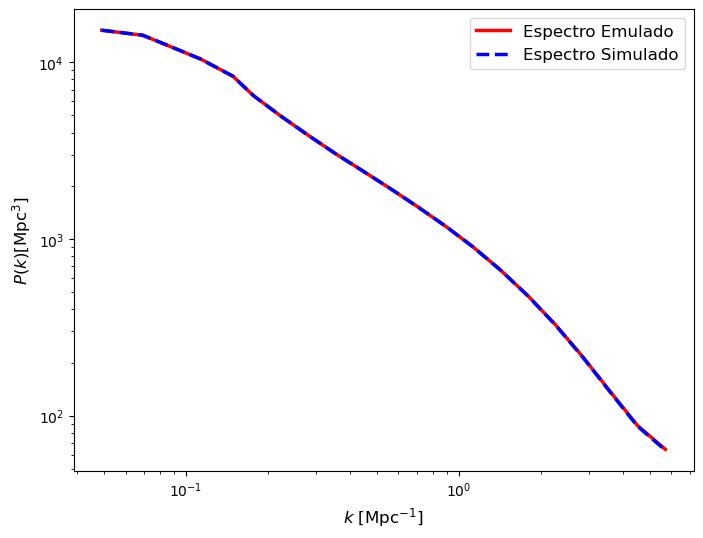

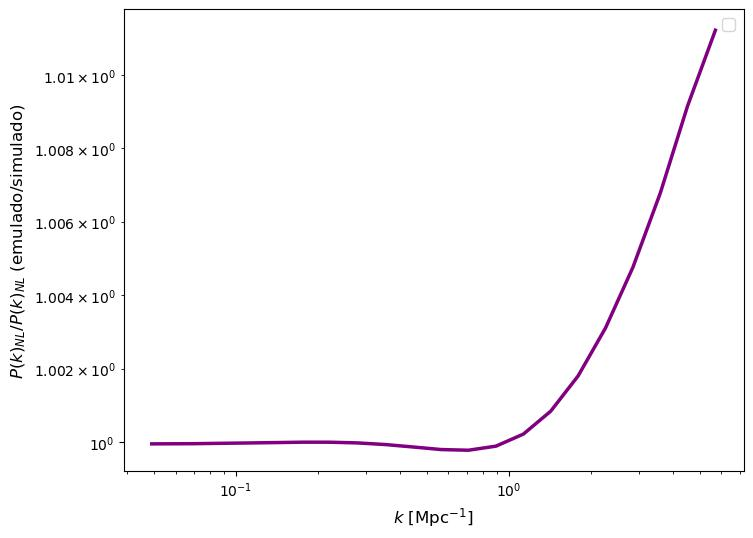

Parâmetros do conjunto 6:
  ω_b = 0.0487, ω_c = 0.2625, A_s_1e9 = 1.6139, n_s = 1.0037, ξ = -0.3499, h = 0.4159, z = 0.0000



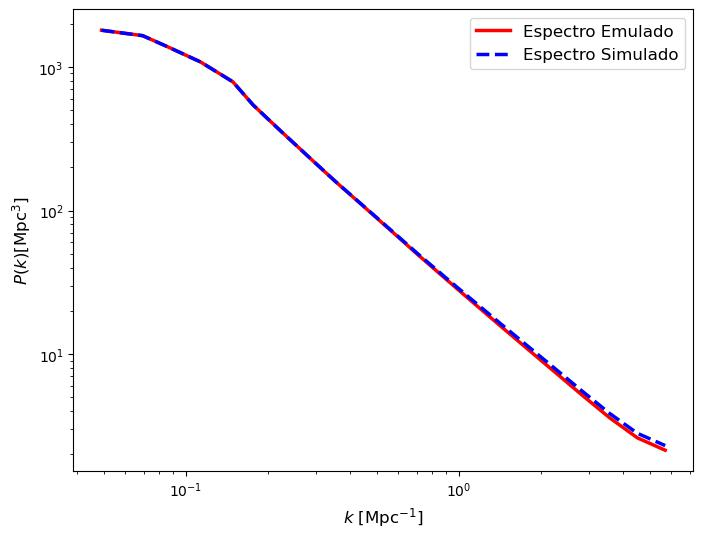

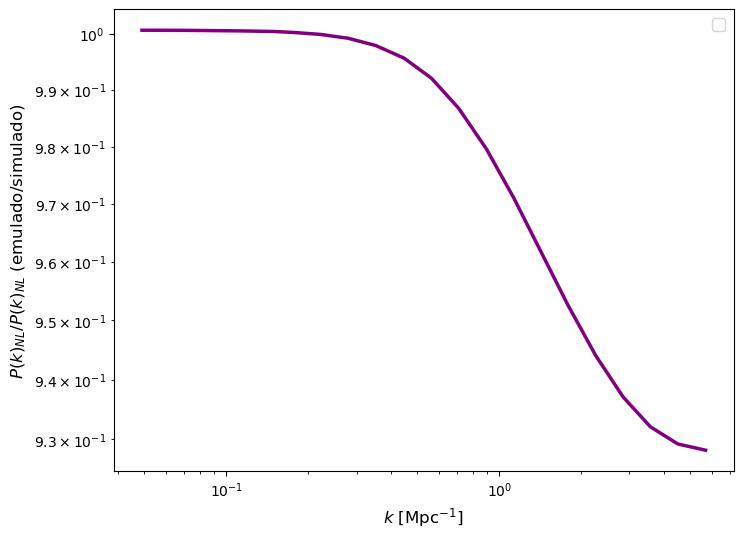

Parâmetros do conjunto 7:
  ω_b = 0.0393, ω_c = 0.3206, A_s_1e9 = 2.8107, n_s = 0.9020, ξ = -0.0346, h = 0.6588, z = 0.0000



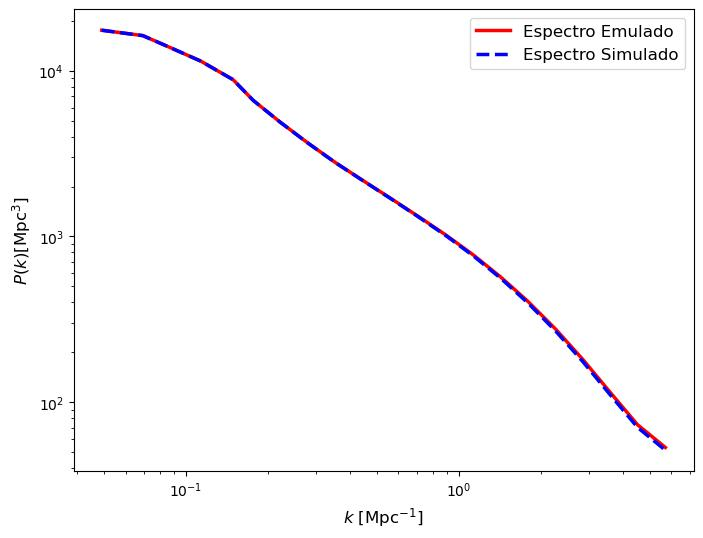

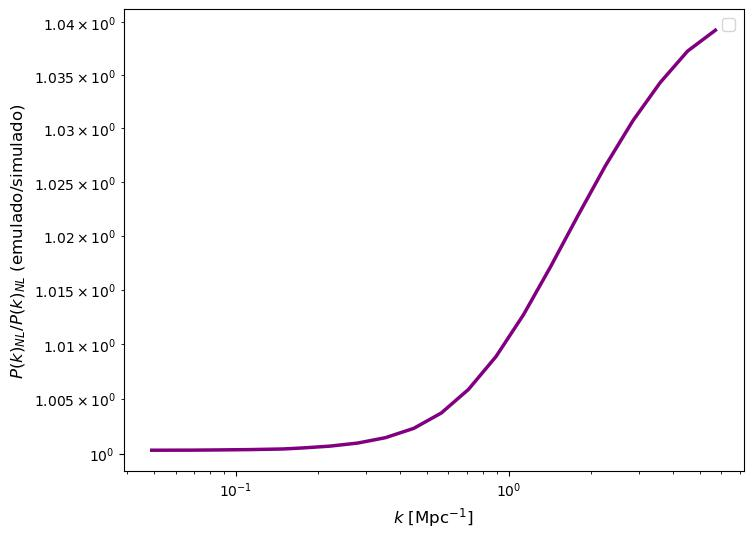

Parâmetros do conjunto 8:
  ω_b = 0.0424, ω_c = 0.3484, A_s_1e9 = 2.9644, n_s = 1.0052, ξ = -0.3461, h = 0.6509, z = 0.0000



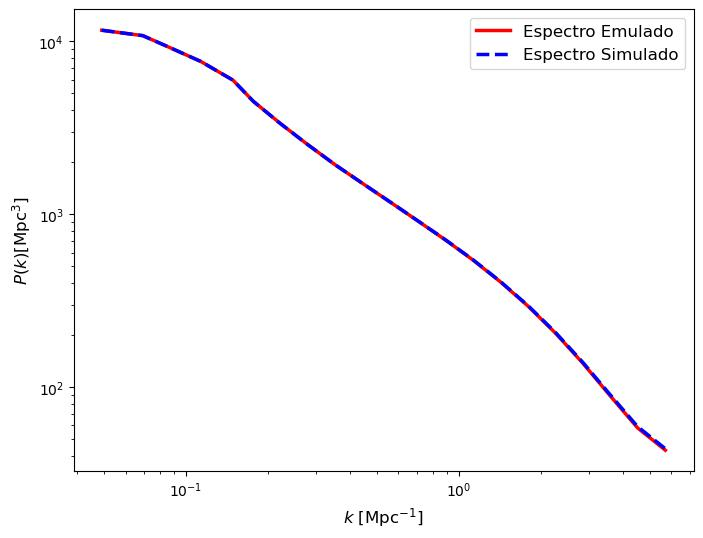

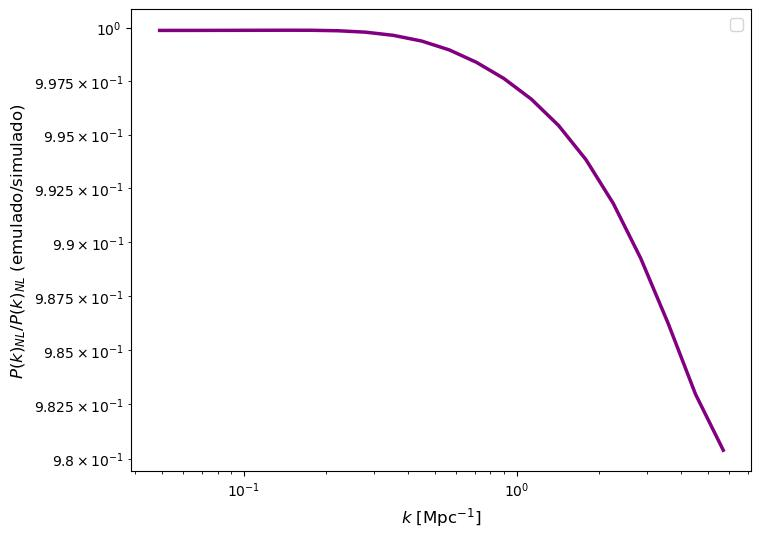

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Função que gera parâmetros cosmológicos aleatórios dentro de intervalos razoáveis
def generate_random_params(n_samples):
    params = []
    for _ in range(n_samples):
        omega_b = np.random.uniform(0.039, 0.053)  # Baryonic matter density parameter today
        omega_c = np.random.uniform(0.1, 0.45)     # Cold dark matter density parameter today
        A_s_1e9 = np.random.uniform(1.61, 3)    # Primordial scalar power spectrum amplitude, multiplied by 1e9
        n_s = np.random.uniform(0.9, 1.1)         # Primordial scalar power spectrum spectral index
        xi = np.random.uniform(-0.5, 0)           # Dimensionless parameter governing the strength of the DM-DE interaction
        h = np.random.uniform(0.4, 0.8)          # Hubble constant in unit of 100 [km/s/Mpc]
        z = 0          # Redshift
        params.append((omega_b, omega_c, A_s_1e9, n_s, xi, h, z))
    return params

# Função que calcula o espectro não linear emulado
def non_linear_spectrum(omega_b, omega_c, A_s_1e9, n_s, xi, h, z):
    cp_nn = cosmopower_NN(restore=True, 
                          restore_filename='trained_model')
    parameters = {
        'omega_b': [omega_b], 
        'omega_c': [omega_c], 
        'A_s_1e9': [A_s_1e9], 
        'n_s': [n_s], 
        'xi': [xi],
        'h': [h],
        'z': [z],
    }
    power_spectra = cp_nn.predictions_np(parameters)[0]
    power_spectra = gaussian_filter(power_spectra, sigma=2.5)
    k_modes = cp_nn.modes
    return power_spectra, k_modes

# Função que calcula o espectro usando simulação de N-corpos
def simulate_power_spectrum(omega_b, omega_c, A_s_1e9, n_s, xi, h, z):
    from pmwd import Configuration, Cosmology, boltzmann, white_noise, linear_modes, lpt, nbody, scatter
    from pmwd.spec_util import powspec
    from pmwd.pm_util import fftinv
    from pmwd.vis_util import simshow
    from pmwd import growth
    
    ptcl_spacing = 1
    ptcl_grid_shape = (128,) * 3
    conf = Configuration(ptcl_spacing, ptcl_grid_shape, a_stop=1/(1+z), mesh_shape=2)  
    
    cosmo = Cosmology(conf, A_s_1e9=A_s_1e9, n_s=n_s, Omega_c=omega_c, Omega_b=omega_b, xi_=xi, h=h)
    cosmo = boltzmann(cosmo, conf)

    seed = 0
    modes = white_noise(seed, conf)
    modes = linear_modes(modes, cosmo, conf)
    
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    dens = scatter(ptcl, conf)
    k, P, _, _ = powspec(dens, conf.cell_size)
    P = gaussian_filter(P, sigma=2.5)
    
    return k, P

def compare_spectra(n_samples=8):
    random_params = generate_random_params(n_samples)
    
    # Exibir os parâmetros gerados
    for i, params in enumerate(random_params):
        print(f"Parâmetros do conjunto {i+1}:")
        print(f"  ω_b = {params[0]:.4f}, ω_c = {params[1]:.4f}, A_s_1e9 = {params[2]:.4f}, "
              f"n_s = {params[3]:.4f}, ξ = {params[4]:.4f}, h = {params[5]:.4f}, z = {params[6]:.4f}\n")
        
        omega_b, omega_c, A_s_1e9, n_s, xi, h, z = params
        # Calcular espectros
        emulated_spectrum, k_modes_emulated = non_linear_spectrum(omega_b, omega_c, A_s_1e9, n_s, xi, h, z)
        k_simulated, simulated_spectrum = simulate_power_spectrum(omega_b, omega_c, A_s_1e9, n_s, xi, h, z)
        
        # Plotar comparação
        plt.figure(figsize=(8, 6))
        plt.loglog(k_modes_emulated, emulated_spectrum, label="Espectro Emulado", color='red', linewidth=2.5)
        plt.loglog(k_simulated, simulated_spectrum, label="Espectro Simulado", color='blue', linestyle='--', linewidth=2.5)
        plt.xlabel('$k$ [Mpc$^{-1}]$', fontsize=12)
        plt.ylabel('$P(k)[\mathrm{Mpc}^3]$', fontsize=12)
        #plt.xlim(0.05,5)
        plt.legend(fontsize=12)
        plt.show()

        # Plotar comparação
        plt.figure(figsize=(8, 6))
        plt.loglog(k_modes_emulated, emulated_spectrum/simulated_spectrum, color='purple', linewidth=2.5)
        plt.xlabel('$k$ [Mpc$^{-1}]$', fontsize=12)
        plt.ylabel('$P(k)_{NL}/P(k)_{NL}$ (emulado/simulado)', fontsize=12)
        #plt.xlim(0.05,5)
        plt.legend(fontsize=12)
        plt.show()

# Executar comparação para 5 conjuntos de parâmetros
compare_spectra(8)